# Q1

In [72]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants

from functools import partial
import pandas as pd
import sympy as sp
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt     #Permet de générer des graphiques.
import timeit

eV_to_MeV = 1e-6            #Convertion eV vers MeV.
c = c * 1e2 # m/s -> cm/s
m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm


In [86]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide


Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique (T). Pour expliciter la dépendance en T de Scol, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation I de ces matériaux sur le site du NIST également. L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

**Équation 9 :**
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
**Équation 10 :**
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

**Équation 3:**
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
**Équation 4:**
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$
-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD-------------

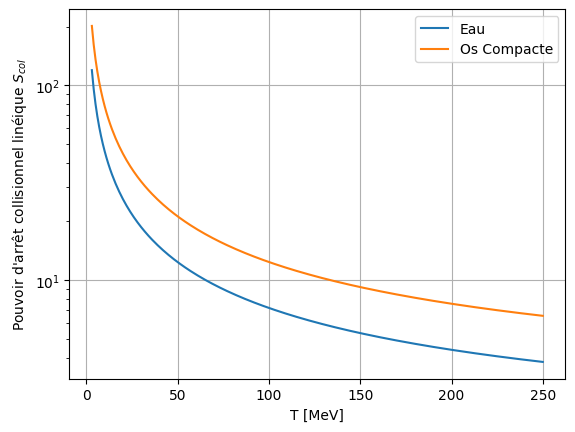

In [74]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.


# %%
def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.yscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

<hr style="border-color:#D4D4D4">

## <ins>Question 2 - Code Veillette</ins>

In [75]:
def S_col(T, n_e, I_MeV):
    gamma = T/(m_p*c**2) + 1
    T_max = (2*m_e*c**2 * (gamma**2 - 1))/(1 + 2*(m_e/m_p)*gamma + (m_e/m_p)**2)
    beta = (gamma**2/(gamma**2 - 1))**(-1/2)
    U = (2 * np.pi * r_e**2 * m_e * c**2 * n_e)
    S_col =  U / (beta**2+np.finfo(np.float64).eps) * (np.log(np.finfo(np.float64).eps + (2 * m_e * c**2 * beta**2 * gamma**2 * T_max) / I_MeV**2) - 2 * beta**2)
    return S_col

SCol_bone = partial(S_col, n_e=n_e_bone, I_MeV=I_bone)
SCol_water = partial(S_col, n_e=n_e_water, I_MeV=I_water)

In [76]:

T = np.linspace(3,250,10000)

S_col_water = SCol_water(T)
S_col_bone = SCol_bone(T)
print(f"Kinetic energy T: {T}")
print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")

Kinetic energy T: [  3.           3.02470247   3.04940494 ... 249.95059506 249.97529753
 250.        ]
Stopping Power S_col_bone: [201.53041683 200.2754518  199.03774391 ...   6.74733696   6.74693993
   6.74654298] MeV/cm
Stopping Power S_col_water: [119.51148821 118.75692437 118.01284502 ...   3.91108912   3.91085806
   3.91062704] MeV/cm


In [ ]:
def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.yscale('log')  # Axe des y en échelle logarithmique
    plt.xlim([0, 250])
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Portée des protons dans la matière**
## ***Question 3***
Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


### <ins>Pour l'eau liquide:</ins>

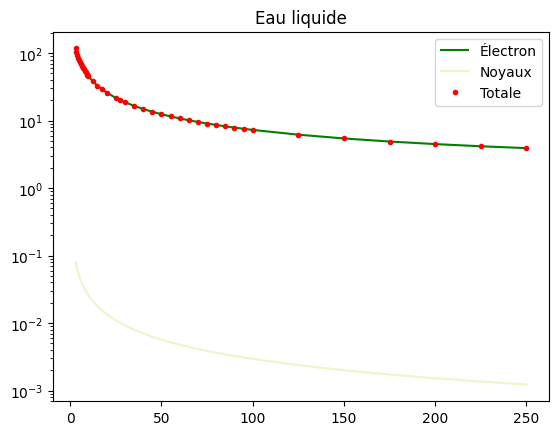

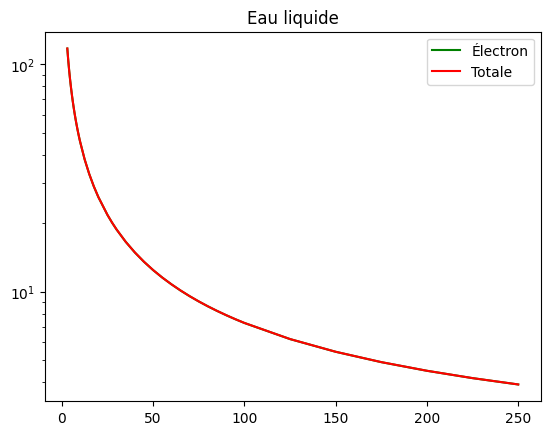

In [51]:
Ke_Mev_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()
plt.show()

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, 'r-',label="Totale")
plt.legend()

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

### <ins>Pour l'os compact:</ins>

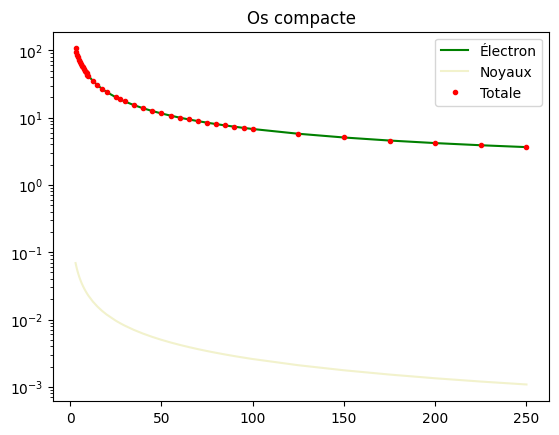

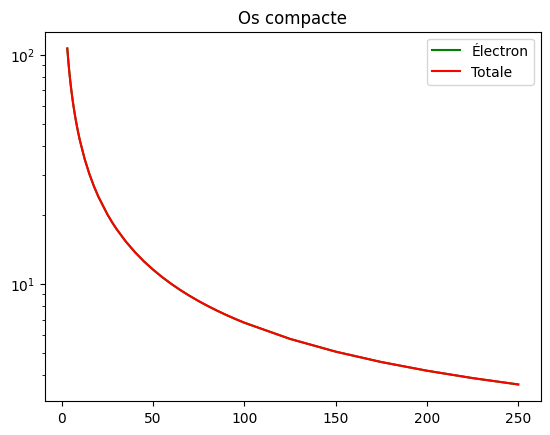

In [52]:

Ke_Mev_os_compact , \
Stopping_power_Electronic_os_compact, \
Stopping_power_Nuclear_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Os compacte")

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, 'r-',label="Totale")
plt.legend()

plt.show()

<hr style="border-color:#D4D4D4">

## ***Question 4***

À partir de l'équation suivante 
$ 
\frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} 
$
on peut réexprimer dx en fonction du reste,
$$
dx = -\frac{dT}{S_{col}}
$$
On obtient ensuite,
$$ 
x = -\int^{T_i}_0 \frac{dT}{S_{col}}
$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


In [53]:
def inverse(func):
    def wrapper(*args):
        res = func(*args)
        return 1/res
    return wrapper
    

<hr style="border-color:#D4D4D4">

## ***Question 5***


Il s'agit d'une équation compliqué, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

<hr style="border-color:#D4D4D4">

## ***Question 6***

In [54]:
from functools import cache
from dataclasses import dataclass

@cache
def Romberg(f, a, b, tol=np.finfo(float).eps, allR=False, with_eps=False):
    def h(k):
        return (b - a) / (2 ** k)
    MAX_STEP = 40
    R = np.zeros((MAX_STEP, MAX_STEP))
    R[0, 0] = 0.5 * (b - a) * (f(a) + f(b))
    
    for n in range(1, MAX_STEP):
        h_n = h(n)
        midpoints = np.array([a + (2 * k - 1) * h_n for k in range(1, 2 ** (n-1) + 1)])
        R[n, 0] = 0.5 * R[n - 1, 0] + h_n * np.sum(f(midpoints))
        for m in range(1, n + 1):
            R[n, m] = (4 ** m * R[n, m - 1] - R[n - 1, m - 1]) / (4 ** m - 1)

        if abs(R[n, n] - R[n - 1, n - 1]) <= tol:
            print(f"nombre de slice: {2**n}")
            if allR:
                return R if not with_eps else (R, abs(R[n, n] - R[n - 1, n - 1]))
            return R[n, n] if not with_eps else (R[n,n], abs(R[n, n] - R[n - 1, n - 1]))
    if allR:
        return R if not with_eps else (R, abs(R[n, n] - R[n - 1, n - 1]))
    return R[n, n] if not with_eps else (R[n,n], abs(R[n, n] - R[n - 1, n - 1]))

@cache
def trapz(f,a,b,tol=np.finfo(float).eps, TRY=10, allR=False, with_eps=False):
    I = 0.5 * (b - a) * (f(a) + f(b)) # un seul trapèze
    h_n = (b - a)/2
    R = np.zeros(TRY)
    R[0] = I
    @cache
    def mid(a, h_n, b, n):
        sum_midpoints = np.sum(f(np.linspace(a + h_n, b - h_n, 2**(n))))
        return sum_midpoints

    for n in range(1, TRY):
        h_n /= 2
        sum_midpoints = mid(a, h_n, b, n)
        new_I = 0.5 * I + h_n * sum_midpoints
        R[n] = new_I
        error_estimate = abs(I - new_I) / 3
        if error_estimate <= tol:
            print("convergence sous la précision machine")
            print(f"nombre de slice: {2**n}", new_I)
            if allR:
                return R if not with_eps else (R, error_estimate)
            return new_I if not with_eps else (new_I, error_estimate)
        I = new_I
    print(f"nombre de slice: {2**TRY}, error estimate: {error_estimate}")
    if allR:
        return R if not with_eps else (R, error_estimate)
    return I if not with_eps else (I, error_estimate)

### <ins>Os compacte:</ins>

In [55]:
os_romb = Romberg(inverse(SCol_bone), 3, 150,with_eps=True)

nombre de slice: 262144


In [56]:
os_trapz = trapz(inverse(SCol_bone), 3, 150, TRY=26,with_eps=True)

nombre de slice: 67108864, error estimate: 6.829780592928121e-09


### <ins>Eau liquide:</ins>

In [57]:
eau_romb = Romberg(inverse(SCol_water), 3, 150,with_eps=True)

nombre de slice: 16384


In [58]:
eau_trapz = trapz(inverse(SCol_water), 3, 150,TRY=26,with_eps=True)

nombre de slice: 67108864, error estimate: 1.1669816520528306e-08


<hr style="border-color:#D4D4D4">

## ***Question 7***
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

### <ins>Os compacte et eau liquide</ins>

In [59]:
def getNRes(R):
    res = np.diag(R)
    res = res[res!=0]
    N = [2**i for i in range(res.shape[0])]
    return N, res

nombre de slice: 262144
nombre de slice: 16384
nombre de slice: 1048576, error estimate: 4.371069414569699e-07
nombre de slice: 1048576, error estimate: 7.468701248569687e-07


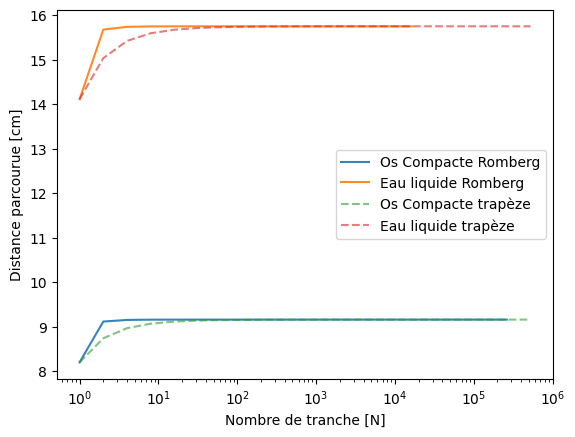

In [60]:

plt.semilogx(*getNRes(Romberg(inverse(SCol_bone), 3, 150, allR=True)), "-",label="Os Compacte Romberg", alpha=0.9)
plt.semilogx(*getNRes(Romberg(inverse(SCol_water), 3, 150, allR=True)), "-",label="Eau liquide Romberg", alpha=0.9)
plt.semilogx(*getNRes(trapz(inverse(SCol_bone), 3, 150, TRY=20, allR=True)), "--",label="Os Compacte trapèze", alpha=0.6)
plt.semilogx(*getNRes(trapz(inverse(SCol_water), 3, 150, TRY=20, allR=True)), "--",label="Eau liquide trapèze", alpha=0.6)

plt.legend()
plt.xlabel("Nombre de tranche [N]")
plt.ylabel("Distance parcourue [cm]")
plt.show()



# **Estimation analytique de l'erreur** 
**À faire pour la Q7**

In [115]:

# Perform substitution of the constants into the derivative


In [114]:
from sympy import symbols, pi, ln, diff, simplify, sqrt

T, m_p, c, r_e, m_e, n_e, I, a, b, delta = symbols('T m_p c r_e m_e n_e I a b delta', positive=True)
U = 2 * pi * r_e * m_e * c**2 * n_e
gamma = ((T / (m_p * c**2)) + 1)
beta = sqrt((gamma**2 - 1)/gamma**2)
T_max = (2 * m_e * c**2 * (gamma**2 - 1))/(1 + 2*gamma *(m_e/m_p) + (m_e/m_p)**2)


S_col = U * (1 / beta**2) * (
    ln((2*m_e*c**2 *beta**2 * gamma**2 * T_max) / (I**2) ) - 2 * beta**2
)

dS_col_inv_dT = diff(1/S_col, T)
dSidT = simplify(dS_col_inv_dT)

def const(Tval=3 , Ival=I_bone, ne=n_e_bone):
    constants = {
        c: 299792458.0 * 1e2,  # speed of light in cm/s
        m_e: 9.10938356e-31 * 1e3,  # electron mass in g
        m_p: 1.6726219e-27 * 1e3,  # proton mass in g
        e: 1.602176634e-19,  # elementary charge in C
        Avogadro: 6.02214076e23,  # Avogadro's number in mol^-1
        n_e: ne,  # Example value for n_e, you can replace it with the actual value
        r_e: 2.8179403e-15 * 1e2,  # Classical electron radius in centimeters (just as an example)
        T: Tval, # MeV
        I: Ival
    }
    return constants

def f(x,isbone=True):
    if isbone:
        cstx = const(Tval=x)
    else:
        cstx = const(Tval=x, Ival=I_water, ne = n_e_water)
    return dSidT.subs(cstx)

In [116]:
def epsilontrapz(a, b, N, isbone=True):
    h = (a-b)/N
    eps = 1/12 * h*2 * np.abs(f(a,isbone=isbone) - f(b,isbone=isbone)) 
    return eps
epsilontrapz(3,150,N=15)

-1.78595799053161e-8/pi

<hr style="border-color:#D4D4D4">

## ***Question 9***

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Optimisation**
## ***Question 10***

In [ ]:
energy_proton = scipy.stats.moyal.rvs(loc=150, scale=4, size=10000)
plt.hist(energy_proton, bins=100)
plt.show()


<hr style="border-color:#D4D4D4">

## ***Question 11***

<hr style="border-color:#D4D4D4">

## ***Question 12***

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Énergie déposée**
## ***Question 13***

<hr style="border-color:#D4D4D4">

## ***Question 14***
### On nomme cette courbe le pic de Bragg. En déduire l'intérêt des protons en radiothérapie.

Contrairement aux photons ou aux électrons, qui perdent leur énergie petit à petit, les protons ont un comportement bien différent : ils déposent d’abord très peu d’énergie, puis lâchent quasiment tout d’un coup juste avant de s’arrêter. Du moins c'est ce qu'on observe dans la courbe de Bragg.

C’est très utile en radiothérapie, parce que ça permet de viser une tumeur avec une précision chirurgicale, sans trop toucher les tissus sains autour. C’est exactement ce qu’on recherche pour traiter efficacement sans causer trop de dégâts collatéraux.

<hr style="border-color:#D4D4D4">

## ***Question 15***
### Selon vous, est-il nécessaire de calculer les portées jusqu'à la precision machine en protonthérapie? Pourquoi?

Non, la précision La taille des cellules humaines varie en fonction de leur type et de leur fonction. En moyenne, une cellule humaine mesure environ 15 micromètres (µm) de diamètre. 
 Cependant, cette dimension peut fluctuer considérablement. Par exemple, les globules rouges ont un diamètre d'environ 7 à 8 µm, tandis que les ovules, qui sont parmi les plus grandes cellules humaines, atteignent environ 100 µm de diamètre. 

La taille des cellules humaines varie en fonction de leur type et de leur fonction. En moyenne, une cellule humaine mesure environ **15 micromètres (µm)** de diamètre ([source](https://www.assistancescolaire.com/eleve/1ST2S/biologie-et-physiopathologie-humaines/reviser-le-cours/1st2s_bio02)).  

La précision machine est de l'ordre de $10^{-16}$, ce qui représente une exagération d’environ $10^{10}$ par rapport à la taille d'une cellule. De toute façon, la position exacte des cellules dans le corps d'un patient vivant fluctue constamment (respiration, battements cardiaques, etc.).  

Autrement dit, on chercherait à viser un point avec une précision extrême… alors que ce point ne serait même plus au bon endroit au moment du tir !


<hr style="border-color:#D4D4D4">

## ***Question 16***
### En quoi les protons sont-ils préférables aux protons pour traiter un mélanome oculaire?

les photons (rayons X utilisés en radiothérapie conventionnelle) traversent les tissus de manière diffuse, irradiant aussi bien la tumeur que les tissus sains situés avant et après celle-ci. En comparaison, les protons on un dépot d'énergie plus précis, tel qu'indiqué dans les questions précédantes. Ceci permet de mieux protéger les différents organes sensibles dans l'oeil tel que la rétine et le nerf optique.

<hr style="border-color:#D4D4D4">

## ***Question 17***
### Dans l'approche développée ici, les protons vont essentiellement en ligne droite dans la matière. Est-ce réaliste? Que devra-t-on éventuellement ajouter à notre modèle?

Pas tout à fait. En effet, les protons vont subir des intéractions coulombiennes avec les particules présentes dans le corps durant leur trajet, ces intéractions seront de plus en plus importantes à mesure que la vitesse des protons sera faible. De plus, ceux ci pourrait entré en collision avec dautres noyaux, pouvant modifier leur trajectoire. Cette dispertion semi-aléatoire se réprésente par une distribution gaussienne autour de la ligne droite utilisé dans notre model.